# Домашнее задание №3: Логистическая регрессия, SVM.

<span style="color: red; font-size: 14pt">Дедлайн: 18.04.24, 08:00</span>

**Оформление ДЗ**:

- Выполненное ДЗ сохраните в файл ``ml_b2c2024q2_<фамилия>_HW03.ipynb`` (пример ``ml_b2c2024q2_dral_HW03.ipynb``)
- Зарегистрироваться и залогиниться в сервисе [Everest](https://everest.distcomp.org/)
- Перейти на страницу приложения: [BDT-grader-ML-B2C](https://everest.distcomp.org/apps/BigDataTeam/BDT-grader-ML-B2C)
- Выбрать вкладку Submit Job (если отображается иная).
- Выбрать в качестве “Task” значение: ``HW03:linear`` (кодовое название для преподвателей: ``ml.linear``)
- Загрузить в качестве “Task solution” файл с решением
- В качестве Access Token указать тот, который был выслан по почте или в телеграм от аккаунта @bdt_manager
    Например: `` HW3 Linear. Иванов Иван Иванович. ``

**Дополнительные ссылки**
- Настройка локального окружения: https://github.com/big-data-team/ml-course
- Датасеты UCI: https://archive.ics.uci.edu/

**Вопросы**:
- Свои вопросы присылайте в Телеграм.

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по сссылке:

    https://forms.gle/iY5NRn9UfaZ344rbA

### Вопросы на понимание

1. Что такое линейная модель? Какие задачи можно решать с помощью линейных моделей?
2. Какая бывает регуляризация линейных моделей? С какой целью применяется?
3. Какую задачу машинного обучения решает логистическая регрессия?
4. Почему может быть важным использование нормализации в линейных моделях?
5. Каким образом связаны функция потерь (Loss function), функция эмпирического риска (Empirical Risk)
6. Что мы пытаемся оценить при помощи кросс-валидации?
7. За что отвечает / что считает / оптимизирует cross_val_score и GridSearchCV?

### Ответы
1. Модель, постороенная на использовании отображений в семействе линейных функций вида 
$
y=w_0 + w_1 \cdot x_1 + ... + w_n \cdot x_n \\
$
Решаем задачи линейной классификации и линейной регрессии



2. L1(lasso) регуляризация (по сумме модулей весов), L2(ridge) регуляризация (по сумме квадратов весов). Применяется для наложения дополнительнх ограничений на веса, для снижения переобучения модели.

3. Логистическая регрессия определяет вероятность отнесения к целевому классу, используется для задач классификации.

4. Нормализация позволяет привести данные в разных единицах измерения и шкалах к единому виду, что бы иметь возможность сравнивать параметры между собой и использовать для расчета схожести. 

5. Функция потерь ограничивает сверху функцию эмпирического риска, используем для перехода от задач дискретной оптимизации к более простым задачам непрерывной оптимизации.

6. Кросс-валидация дает нам возможность оценить качество работы модели на датасете, методом деления его на обучающую и тестовую выборку.

7. cross_val_score - гибкий метод по расчету точности(скоринга) модели, например используя различные скореры, различные стратегии разбиения. GridSearchCV - автоматизирует формирование сетки гиперпараметров и применение их для построения моделей , накапливает статистику применения гиперпараметров, оптимизирует код для расчета требуемой модели.


### Часть 1. Линейные модели (100%)

Будем работать с подвыборкой из [данных о типе лесного покрытия из репозитория UCI](http://archive.ics.uci.edu/ml/datasets/Covertype). Доступно 7 различных классов. Каждый объект описывается 54 признаками, 40 из которых являются бинарными. Описание данных доступно по ссылке, а так же в файле `covtype.info.txt`.

In [153]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import seaborn as sns
import joblib
import collections
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, make_scorer, roc_curve, auc

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [76]:
all_data = pd.read_csv('forest_dataset.csv')

Выделим 20% данных в `delayed_data` в качестве выборки, на которой будет производиться финальное сравнение моделей.

In [77]:
delayed_data = all_data.iloc[int(len(all_data)*0.8):]
all_data = all_data.iloc[:int(len(all_data)*0.8)]

Выделим значения метки класса в переменную `labels`, признаковые описания в переменную `feature_matrix`. Так как данные числовые и не имеют пропусков, переведем их в `numpy`-формат с помощью метода `.values`.

In [78]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

#### 2.1 Классификация, baseline (10%)

В этом домашнем задании будем работать с двумя типами лесного покрытия. Как решать задачи многоклассовой классификации мы изучим на следующих занятиях. Обучите линейный классификатор для разделения двух классов. Данные разделены на train и test с помощью `train_test_split`.

In [5]:
two_class_labels_indices = (labels == 1) + (labels == 2)

two_class_feature_matrix = feature_matrix[two_class_labels_indices]
two_class_labels = labels[two_class_labels_indices]

In [6]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    two_class_feature_matrix,
    two_class_labels,
    test_size=0.33)

Обучите логистическую регрессию. Оцените качество классификации на отложенной выборке с помощью `accuracy` и `f1_score` ([Wikipedia](https://en.wikipedia.org/wiki/F1_score)).

In [8]:
lr_clf = LogisticRegression()

In [148]:
lr_clf.fit(train_feature_matrix, train_labels)

predictions = lr_clf.predict(test_feature_matrix)
clf_accuracy_score = accuracy_score(test_labels, predictions)
clf_f1_score = f1_score(test_labels, predictions)

print(f'Accuracy score {clf_accuracy_score} F1_score {clf_f1_score}')

Accuracy score 0.7150145772594753 F1_score 0.6536758193091231


#### 2.2 Оптимизация логистической регрессии (50%)

Предоставим возможность задать произвольные два класса для проведения экспериментов, например определив переменные `TARGET_LABEL_A = 1` и `TARGET_LABEL_B = 2` для последующей фильтрации датасета.

In [66]:
TARGET_LABEL_A = 1
TARGET_LABEL_B = 2

Отфильтруйте датасет по двум указанным классам и визуализируйте базовые характеристики датасета (проведите базовый анализ).

In [85]:
two_class_indicies = (labels == TARGET_LABEL_A) + (labels == TARGET_LABEL_B)
pd_two_class = all_data[two_class_indicies]
pd_two_class.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [83]:
pd_two_class.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6856 entries, 0 to 7999
Data columns (total 55 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       6856 non-null   int64
 1   1       6856 non-null   int64
 2   2       6856 non-null   int64
 3   3       6856 non-null   int64
 4   4       6856 non-null   int64
 5   5       6856 non-null   int64
 6   6       6856 non-null   int64
 7   7       6856 non-null   int64
 8   8       6856 non-null   int64
 9   9       6856 non-null   int64
 10  10      6856 non-null   int64
 11  11      6856 non-null   int64
 12  12      6856 non-null   int64
 13  13      6856 non-null   int64
 14  14      6856 non-null   int64
 15  15      6856 non-null   int64
 16  16      6856 non-null   int64
 17  17      6856 non-null   int64
 18  18      6856 non-null   int64
 19  19      6856 non-null   int64
 20  20      6856 non-null   int64
 21  21      6856 non-null   int64
 22  22      6856 non-null   int64
 23  23      6856 non-n

In [86]:
pd_two_class.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
count,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.0,6856.000000,6856.000000,6856.000000,6856.0,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.0,6856.0,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.0,6856.000000,6856.000000,6856.000000,6856.000000
mean,3012.013711,152.578909,13.323221,277.133022,44.186260,2514.068845,213.271149,224.992999,143.538506,2095.928967,0.496791,0.055134,0.442532,0.005543,0.0,0.002188,0.002771,0.008460,0.0,0.002188,0.000292,0.000729,0.003209,0.023629,0.017357,0.058489,0.035443,0.0,0.0,0.003355,0.002480,0.002625,0.009043,0.015315,0.002042,0.064469,0.120187,0.042736,0.000875,0.005688,0.001021,0.001313,0.221266,0.059364,0.055134,0.103705,0.088098,0.002334,0.002188,0.000292,0.0,0.016628,0.017065,0.008022,1.564907
std,199.689175,110.728909,7.014664,216.632352,57.489036,1572.658321,24.695038,18.287507,35.804583,1327.103765,0.500026,0.228259,0.496723,0.074247,0.0,0.046727,0.052574,0.091594,0.0,0.046727,0.017078,0.026997,0.056560,0.151901,0.130607,0.234683,0.184911,0.0,0.0,0.057827,0.049737,0.051175,0.094672,0.122812,0.045146,0.245605,0.325203,0.202277,0.029572,0.075212,0.031939,0.036210,0.415130,0.236322,0.228259,0.304899,0.283458,0.048256,0.046727,0.017078,0.0,0.127881,0.129524,0.089213,0.495805
min,2282.000000,0.000000,0.000000,0.000000,-147.000000,0.000000,82.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
25%,2887.000000,55.000000,8.000000,108.000000,5.000000,1253.000000,201.000000,215.000000,121.000000,1167.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
50%,3023.000000,127.000000,12.000000,234.000000,27.000000,2217.000000,218.000000,227.000000,143.000000,1831.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000
75%,3165.250000,249.250000,17.000000,400.000000,65.000000,3508.500000,231.000000,238.000000,167.000000,2638.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000
max,3608.000000,359.000000,57.000000,1370.000000,573.000000,7023.000000,254.000000,254.000000,246.000000,7080.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.

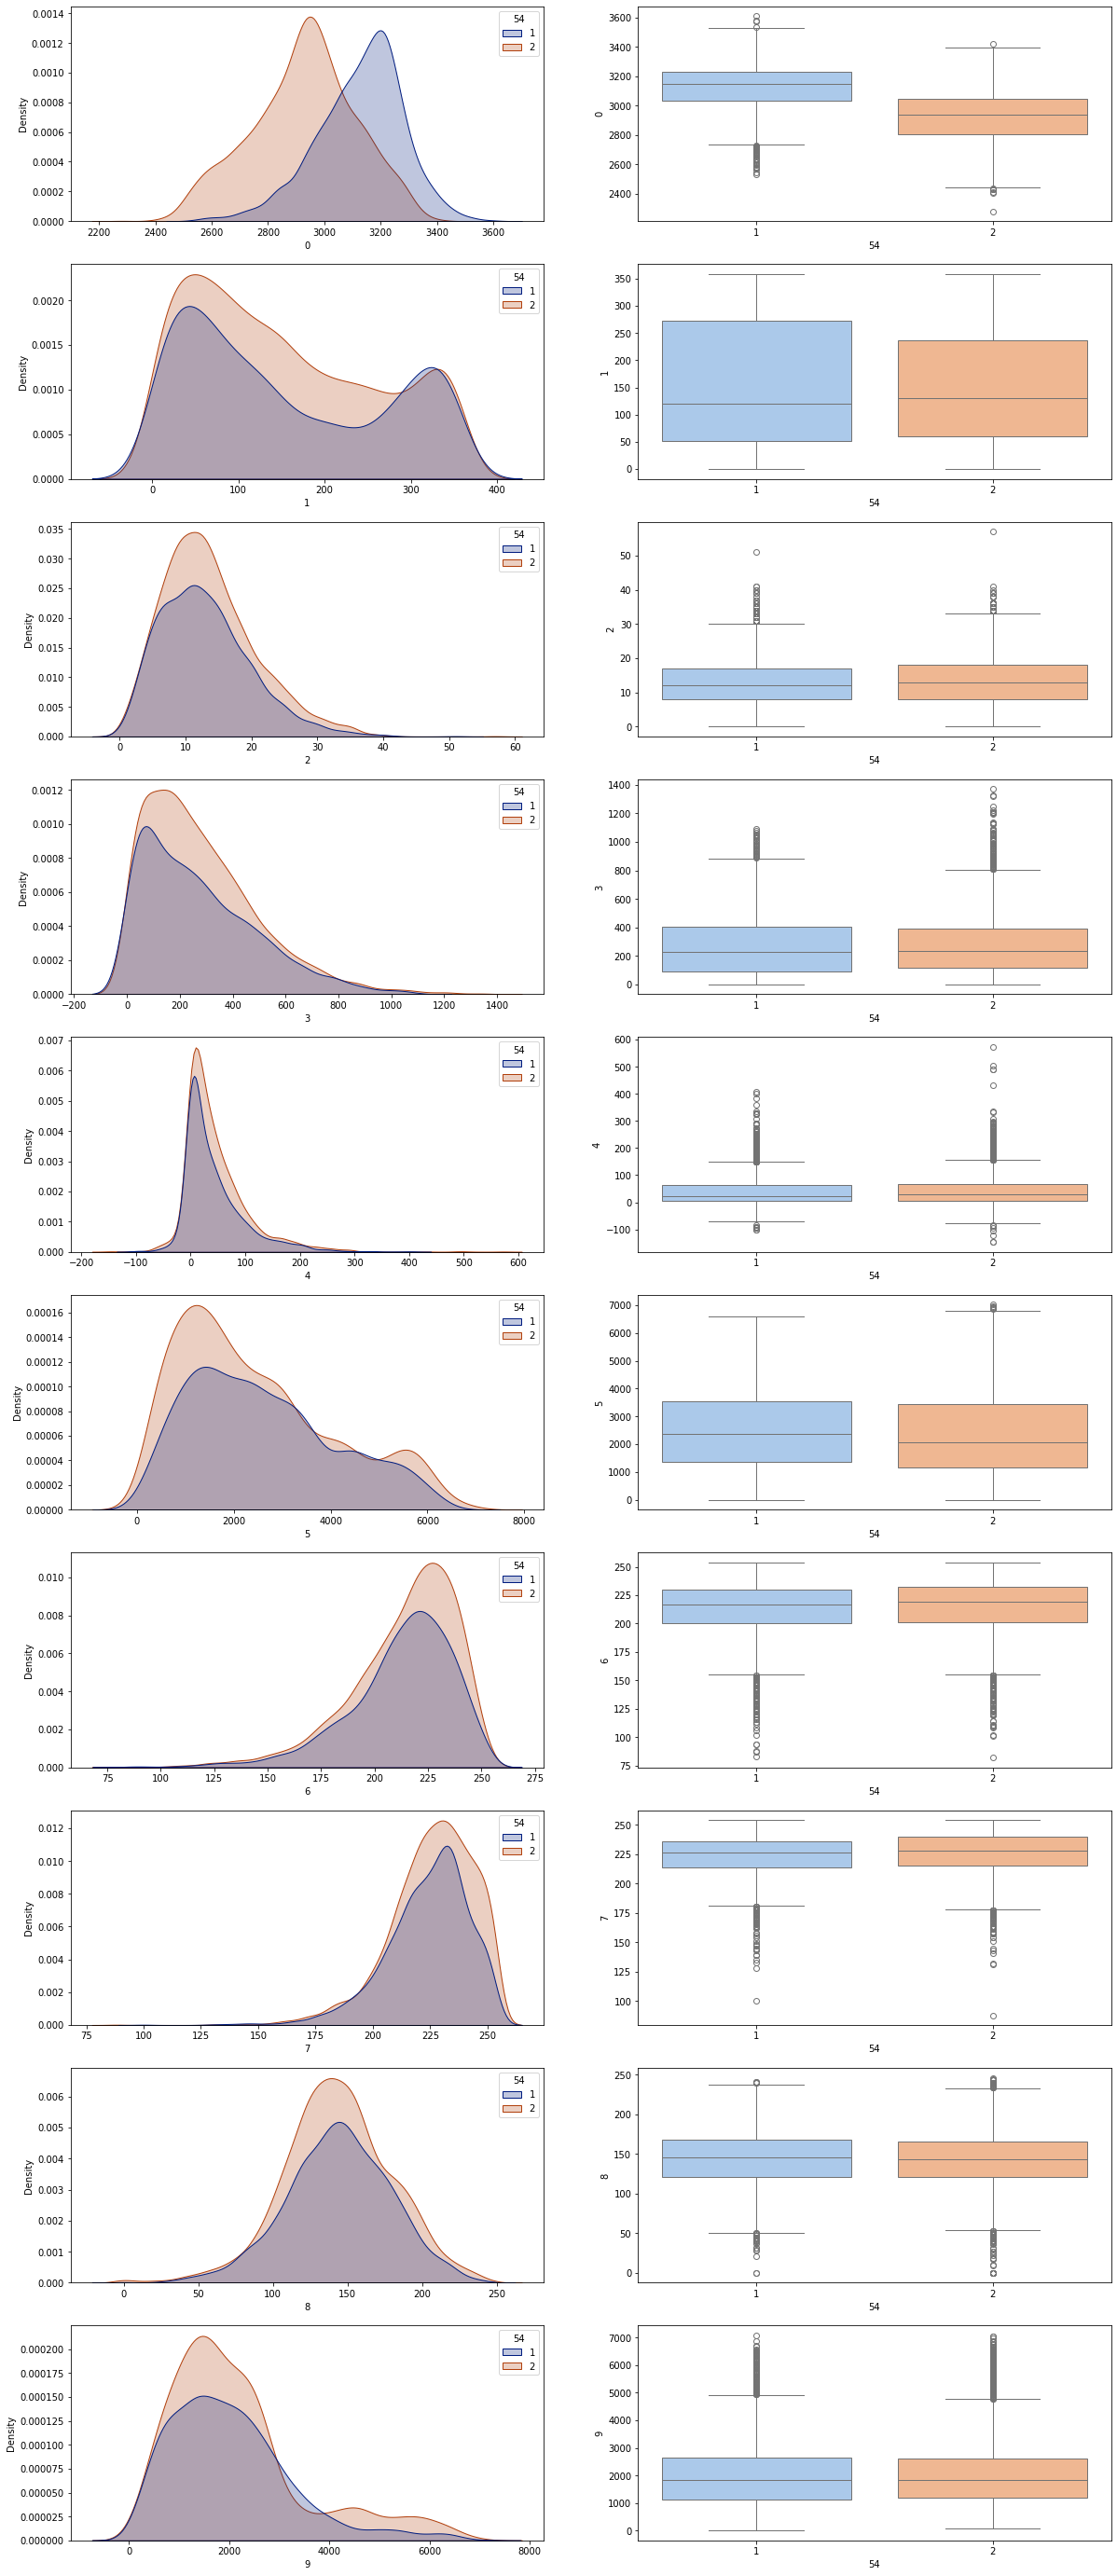

In [103]:
cont_vars = [str(x) for x in range(0,10)] # непрерывные параметры - 10 
# тип покрытия - 54 столбец - выделяем как labels

fig, axs = plt.subplots(10, 2, figsize=(20,50))

for i in range(len(cont_vars)):
    
    sns.kdeplot(data = pd_two_class, x = cont_vars[i], hue = '54', palette = 'dark', fill = True, ax = axs[i][0])
    sns.boxplot(data = pd_two_class, y = cont_vars[i], x = '54', palette = 'pastel', ax = axs[i][1])
    


Разделите выборку на обучающую и тестовую с помощью метода `train_test_split` с параметрами `test_size=0.2`, `random_state=42`. Обучите логистическую регрессию на данном датасете.

In [28]:
lr_clf = LogisticRegression(solver= 'saga')

train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    two_class_feature_matrix,
    two_class_labels,
    test_size=0.2,
    random_state = 42)
lr_clf.fit(train_feature_matrix, train_labels)

LogisticRegression(solver='saga')

Для подбора параметров модели нужно правильно оценить ее качество. Будем делать это с помощью кросс-валидации. Для автоматизации подбора доступен класс `GridSearchCV`, позволяющий перебрать заданные параметры по сетке и выбрать лучший с точки зрения выбранной функции качества.

Документация доступна по [ссылке](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `С` и `penalty`. Для параметра `C` используйте набор значений `np.linspace(0.01, 1, 10)`, а для `penalty` - `['l1', 'l2']`. Критерий качества `scoring = 'accuracy'`.

In [147]:
%%time
lr_clf.get_params()
params_grid = {
    'C': np.linspace(0.01, 1, 10), 
    'penalty': ['l1', 'l2'],
}

grid_cv_lr = GridSearchCV(lr_clf, params_grid, scoring='accuracy', cv = 5)
grid_cv_lr.fit(train_feature_matrix, train_labels)

joblib.dump(grid_cv_lr, 'grid_cv_lr.joblib') # сохраним поиск по сетке для lr 

CPU times: user 28.5 s, sys: 1min 3s, total: 1min 32s
Wall time: 18.2 s


['grid_cv_lr.joblib']

Постройте графики средних значений критерия качества `accuracy` для типов регуляризации `l1` и `l2` в зависимости от коэффициента регуляризации `C`.

In [37]:
grid_cv_lr.cv_results_['param_C']
grid_cv_lr.best_params_

{'C': 0.78, 'penalty': 'l2'}

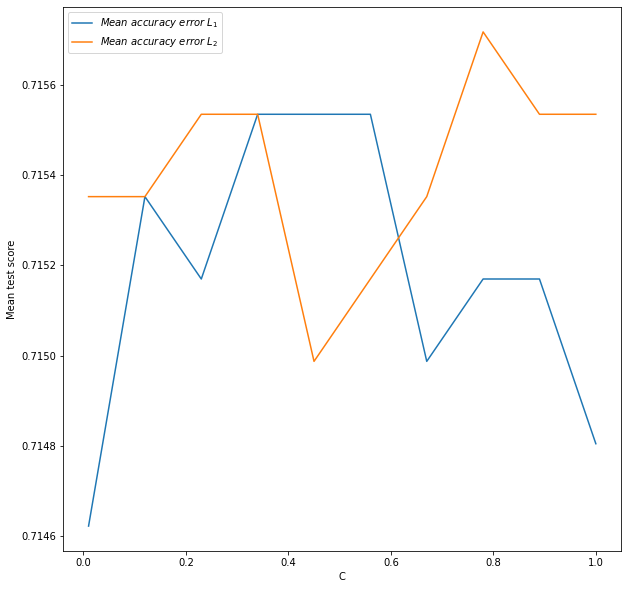

In [119]:
l1_data = np.array([[y['C'], grid_cv_lr.cv_results_['mean_test_score'][x]]
               for x, y in enumerate(grid_cv_lr.cv_results_['params']) if y['penalty']=='l1'])

l2_data = np.array([[y['C'], grid_cv_lr.cv_results_['mean_test_score'][x]] 
               for x, y in enumerate(grid_cv_lr.cv_results_['params']) if y['penalty']=='l2'])

plt.figure(figsize = (10, 10))

plt.plot(l1_data[:, 0],
         l1_data[:, 1])
plt.plot(l2_data[:, 0],
         l2_data[:, 1])
plt.legend(["$Mean \ accuracy \ error \ L_1$", 
            "$Mean \ accuracy \ error \ L_2$"])
plt.ylabel("Mean test score")
plt.xlabel("C")
plt.show()

Проанализируйте полученные графики. Чему равны найденные оптимальные значения параметров `C` и `penalty`?

In [ ]:
#C = 0.78, penalty = l2

Используя найденные оптимальные значения `C` и `penalty`, обучите логистическую регрессию на обучающей выборке (train) и вычислите вероятности принадлежности к классам для тестовой (test)  выборки (`best_lr_clf.predict_proba`).

In [38]:
best_lr_clf = LogisticRegression(solver = 'saga', C = 0.78, penalty = 'l2')
best_lr_clf.fit(train_feature_matrix, train_labels)
best_lr_clf.predict_proba(test_feature_matrix)

array([[0.59581948, 0.40418052],
       [0.56718044, 0.43281956],
       [0.2867559 , 0.7132441 ],
       ...,
       [0.33949768, 0.66050232],
       [0.38971458, 0.61028542],
       [0.34164081, 0.65835919]])

*Optional: Для полученной матрицы вычислите усредненные по всем объектам из тестовой выборки значения вероятностей принадлежности к классам. Сравните ее оценкой вероятности принадлежности к классу на основе частот меток классов в обучающей выборке.* 

In [165]:
test_proba = best_lr_clf.predict_proba(test_feature_matrix).mean(axis=0)
train_proba = best_lr_clf.predict_proba(train_feature_matrix).mean(axis=0)
print(f'mean probabality train {train_proba}\nmean probability test {test_proba}')
actual_train = [
        (train_labels == 1).sum()/len(train_labels), 
        (train_labels == 2).sum()/len(train_labels)]
actual_test = [
        (test_labels == 1).sum()/len(test_labels), 
        (test_labels == 2).sum()/len(test_labels)]
print(f'actual probability train {actual_train}\nactual probability trest {actual_test}')

mean probabality train [0.44258904 0.55741096]
mean probability test [0.44165999 0.55834001]
actual probability train [0.4350838803792852, 0.5649161196207148]
actual probability trest [0.43513119533527694, 0.564868804664723]


#### 2.3 Многоклассовая классификация: SVM (30%)

Попробуйте обучить Support Vector Machine с параметрами по умолчанию на том же датасете.

In [157]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracy = []
for kernel in kernels:
    svm_clf = SVC(kernel = kernel)
    svm_clf.fit(train_feature_matrix, train_labels)
    cross_val_scores = cross_val_score(svm_clf, 
                                        train_feature_matrix , 
                                        train_labels, 
                                        scoring="accuracy", 
                                        cv=5)
    accuracy.append(cross_val_scores)

In [164]:
print (f'Linear acc_mean {accuracy[0].mean()}, acc_std {accuracy[0].std()}')
print (f'Poly acc_mean {accuracy[1].mean()}, acc_std {accuracy[1].std()}')
print (f'RBF acc_mean {accuracy[2].mean()}, acc_std {accuracy[2].std()}')
print (f'Sigmoid acc_mean {accuracy[3].mean()}, acc_std {accuracy[3].std()}')

Linear acc_mean 0.7702418340663655, acc_std 0.014567619345355436
Poly acc_mean 0.7545617111032744, acc_std 0.014814211175574013
RBF acc_mean 0.7558382516351828, acc_std 0.015801072037198664
Sigmoid acc_mean 0.5051141467439401, acc_std 0.027144040829641197


Попробуйте использовать различные ядра: `['linear', 'poly', 'rbf', 'sigmoid']`. Выберите одно из них самостоятельно. Чем обоснован Ваш выбор?

In [ ]:
# Linear - наибольшая acc_mean и наименьшее отклонение ошибки

Переберите по сетке от `0.1` до `3` параметр `C` (не делайте ее слишком плотной, 10 шагов вполне достаточно). Покажите на графике, как менялись значения критерия качества `accuracy` при увеличении параметра `C`.

In [8]:
%%time 
svm_clf = SVC(kernel = 'linear')

params_grid = {
    'C': np.linspace(0.1, 3, 10), 
}
grid_cv_svm = GridSearchCV(svm_clf, params_grid, scoring='accuracy',  verbose = 10)
grid_cv_svm.fit(train_feature_matrix, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=0.1......................................................
[CV 1/5; 1/10] END .......................C=0.1;, score=0.769 total time= 3.9min
[CV 2/5; 1/10] START C=0.1......................................................
[CV 2/5; 1/10] END .......................C=0.1;, score=0.767 total time= 2.6min
[CV 3/5; 1/10] START C=0.1......................................................
[CV 3/5; 1/10] END .......................C=0.1;, score=0.764 total time= 2.8min
[CV 4/5; 1/10] START C=0.1......................................................
[CV 4/5; 1/10] END .......................C=0.1;, score=0.767 total time= 3.4min
[CV 5/5; 1/10] START C=0.1......................................................
[CV 5/5; 1/10] END .......................C=0.1;, score=0.780 total time= 3.1min
[CV 1/5; 2/10] START C=0.42222222222222217......................................
[CV 1/5; 2/10] END .......C=0.42222222222222217;

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': array([0.1       , 0.42222222, 0.74444444, 1.06666667, 1.38888889,
       1.71111111, 2.03333333, 2.35555556, 2.67777778, 3.        ])},
             scoring='accuracy', verbose=10)

In [124]:
joblib.dump(grid_cv_svm, 'grid_cv_svm.joblib') # сохраним поиск для svm

['grid_cv_svm.joblib']

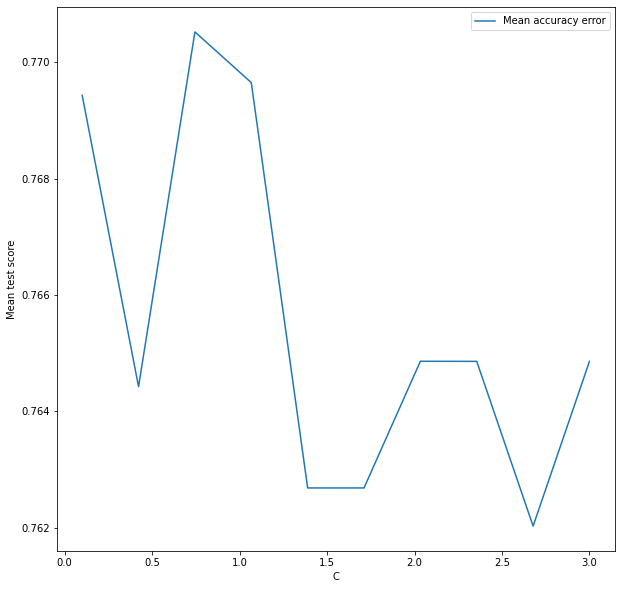

In [146]:
svc_data = np.array([[y['C'], grid_cv_svm.cv_results_['mean_test_score'][x]] 
               for x, y in enumerate(grid_cv_svm.cv_results_['params'])])

plt.figure(figsize = (10, 10))
plt.plot(svc_data[:, 0],
         svc_data[:, 1])
plt.legend(["Mean accuracy error"])
plt.ylabel("Mean test score")
plt.xlabel("C")
plt.show()

Используя найденное оптимальное значение параметра `C`, обучите SVM на обучающей выборке и вычислите вероятности принадлежности к классам для тестовой выборки (`best_svm_clf.predict_proba`). Для этого параметр `probability` нужно присвоить значение `True`.

In [48]:
best_svm_clf = SVC(C=0.74444, kernel = 'linear' , probability=True)
best_svm_clf.fit(train_feature_matrix, train_labels)

SVC(C=0.74444, kernel='linear', probability=True)

#### 2.4 Сравнение результатов логистической регрессии и SVM (10%)

В реальной жизни новые данные становятся доступны с течением времени. Сравните качество Вашей лучшей модели логистической регресии и лучшего SVM  на отложенной выборке `delayed_data`. Какая из них показала лучший результат?

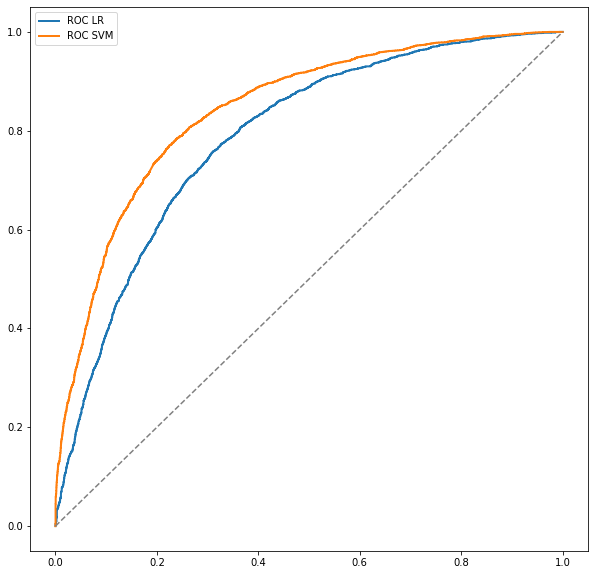

In [141]:
delayed_labels = all_data[delayed_data.columns[-1]].values
delayed_feature_matrix = all_data[delayed_data.columns[:-1]].values

two_class_delayed_labels_indices = (delayed_labels == 1) + (delayed_labels == 2)
two_class_delayed_feature_matrix = delayed_feature_matrix[two_class_labels_indices]

two_class_delayed_labels = delayed_labels[two_class_labels_indices]
two_class_delayed_svm = best_svm_clf.predict_proba(two_class_delayed_feature_matrix)
two_class_delayed_lr = best_lr_clf.predict_proba(two_class_delayed_feature_matrix)

fpr_lr, tpr_lr, thresholds_lr = roc_curve(two_class_delayed_labels,
                                 two_class_delayed_lr[:, 0],
                                 pos_label=1)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(two_class_delayed_labels,
                                 two_class_delayed_svm[:, 0],
                                 pos_label=1)
plt.figure(figsize = (10, 10))
plt.plot(fpr_lr, tpr_lr, lw=2,
         label='Logistic regression')
plt.plot(fpr_svm, tpr_svm, lw=2,
         label='SVM')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
        )
plt.legend(["ROC LR", 
            "ROC SVM"])
plt.show()


In [145]:
print (f'AUC LR = {auc(fpr_lr, tpr_lr):.4f}; AUC SVM = {auc(fpr_svm, tpr_svm):.4f}')

AUC LR = 0.7864; AUC SVM = 0.8422


AUC для SVM больше, SVM модель показала лучший результат

## Решил ДЗ - дай обратную связь ;)

Надеемся, было интересно и полезно.

Пожалуйста, оставьте обратную связь по этому домашнему заданию: https://forms.gle/iY5NRn9UfaZ344rbA